In [65]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import librosa
import numpy as np
import matplotlib.pyplot as plt

import dcase_dataset
import sed_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training data

In [96]:
bioacoustic_conf = sed_utils.get_bioacoustic_pcen_conf()
speech_conf      = sed_utils.get_speech_pcen_conf()

sample_rate = 8000
root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_{}Hz/Training_Set/'.format(sample_rate)
window_size = 4096
hop_size = window_size // 2
include_background = False
n_classes = 48
n_time = 4

# Hacky....
audio_scaling = 1 #2**32 # TODO: Why does this scaling has such an effect?
transform_mel = lambda x: sed_utils.wav_to_mel(x - (np.sum(x)/np.size(x)), sample_rate)
transform_pcen_bio = lambda x: sed_utils.wav_to_pcen(x - (np.sum(x)/np.size(x)), sample_rate, bioacoustic_conf)
transform_pcen_sch = lambda x: sed_utils.wav_to_pcen(x - (np.sum(x)/np.size(x)), sample_rate, speech_conf)

base_dataset_pcen_bio = dcase_dataset.BioacousticBaseDataset(
    root_dir           = root_path,
    window_size        = window_size,
    hop_size           = hop_size,
    sample_rate        = sample_rate,
    n_classes          = n_classes,
    n_time             = n_time,
    include_background = include_background, 
    transform          = transform_pcen_bio,
    cache              = True
)

base_dataset_pcen_sch = dcase_dataset.BioacousticBaseDataset(
    root_dir           = root_path,
    window_size        = window_size,
    hop_size           = hop_size,
    sample_rate        = sample_rate,
    n_classes          = n_classes,
    n_time             = n_time,
    include_background = include_background, 
    transform          = transform_pcen_sch,
    cache              = True
)

base_dataset_mel = dcase_dataset.BioacousticBaseDataset(
    root_dir           = root_path,
    window_size        = window_size,
    hop_size           = hop_size,
    sample_rate        = sample_rate,
    n_classes          = n_classes,
    n_time             = n_time,
    include_background = include_background, 
    transform          = transform_mel,
    cache              = True
)

In [94]:
print("x shape: ", base_dataset_mel.x.shape)
print("y shape: ", base_dataset_mel.y.shape)

x shape:  (46274, 4096)
y shape:  (46274, 48, 4)


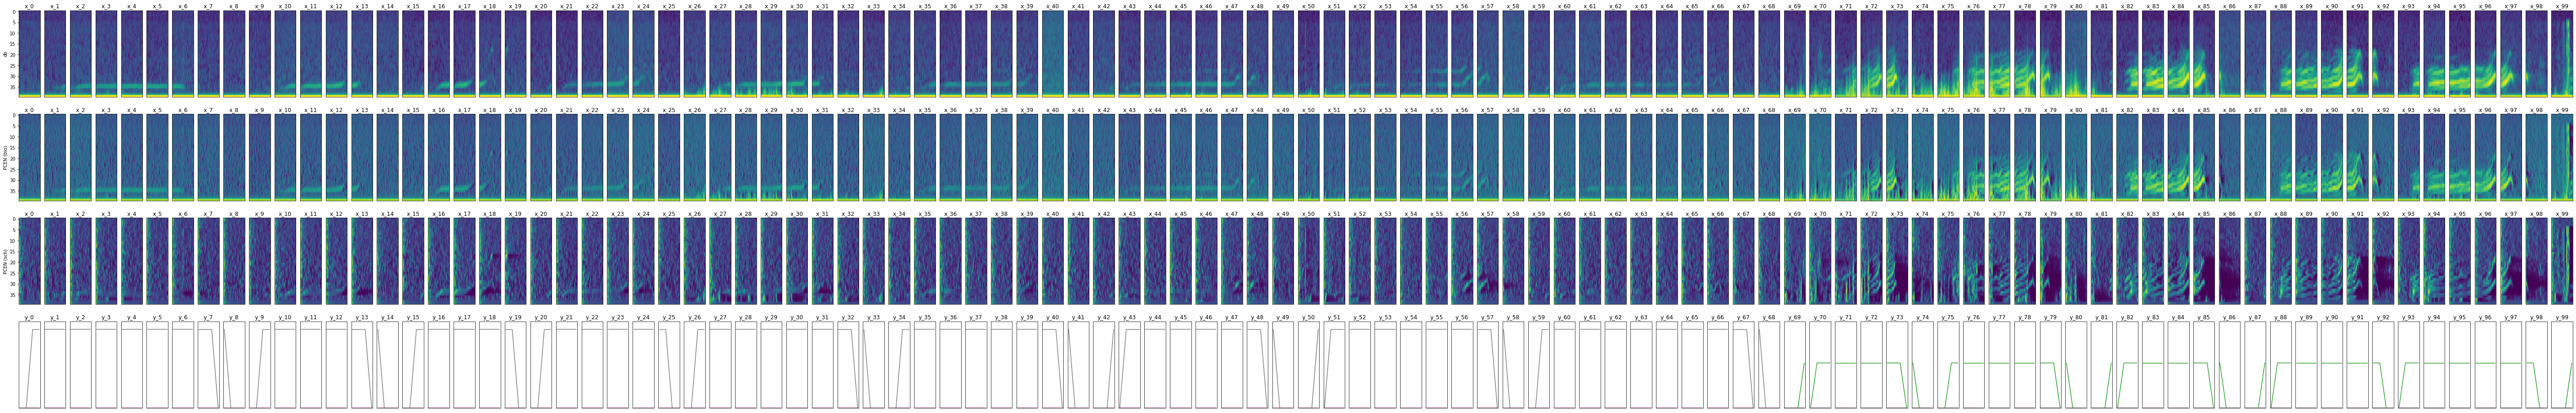

In [95]:
n_segments = np.min((100, base_dataset.x.shape[0]))

fig, ax = plt.subplots(4, n_segments, figsize=(n_segments, 16))

start_idx = 0

for seg_idx in range(start_idx, start_idx+n_segments):
    ax_idx = seg_idx - start_idx
    
    mel_segment,      target_segment = base_dataset_mel[seg_idx]
    pcen_bio_segment, target_segment = base_dataset_pcen_bio[seg_idx]
    pcen_sch_segment, target_segment = base_dataset_pcen_sch[seg_idx]

    ax[0, ax_idx].imshow(np.flip(mel_segment, axis=0), aspect='auto')
    ax[0, ax_idx].get_xaxis().set_visible(False)
    ax[0, ax_idx].get_yaxis().set_visible(False)
    ax[0, ax_idx].set_title('x_{}'.format(seg_idx))
    
    ax[1, ax_idx].imshow(np.flip(pcen_bio_segment, axis=0), aspect='auto')
    ax[1, ax_idx].get_xaxis().set_visible(False)
    ax[1, ax_idx].get_yaxis().set_visible(False)
    ax[1, ax_idx].set_title('x_{}'.format(seg_idx))
    
    ax[2, ax_idx].imshow(np.flip(pcen_sch_segment, axis=0), aspect='auto')
    ax[2, ax_idx].get_xaxis().set_visible(False)
    ax[2, ax_idx].get_yaxis().set_visible(False)
    ax[2, ax_idx].set_title('x_{}'.format(seg_idx))

    scales = np.linspace(0.2, 1.0, len(target_segment))
    for i, ann in enumerate(target_segment):
        ax[3,ax_idx].plot(ann * scales[i])
    ax[3,ax_idx].set_ylim([0, 1.1])
    ax[3, ax_idx].get_xaxis().set_visible(False)
    ax[3, ax_idx].get_yaxis().set_visible(False)
    ax[3, ax_idx].set_title('y_{}'.format(seg_idx))
    
ax[0,0].set_ylabel('db')
ax[1,0].set_ylabel('PCEN (bio)')
ax[2,0].set_ylabel('PCEN (sch)')
ax[0,0].get_yaxis().set_visible(True)
ax[1,0].get_yaxis().set_visible(True)
ax[2,0].get_yaxis().set_visible(True)

(array([308996., 412637., 289790., 135055.,  64283.,  34635.,  20254.,
         34597.,  18212.,   1541.]),
 array([3.25415132e-07, 2.72838271e-01, 5.45676217e-01, 8.18514163e-01,
        1.09135211e+00, 1.36419006e+00, 1.63702800e+00, 1.90986595e+00,
        2.18270389e+00, 2.45554184e+00, 2.72837979e+00]),
 <BarContainer object of 10 artists>)

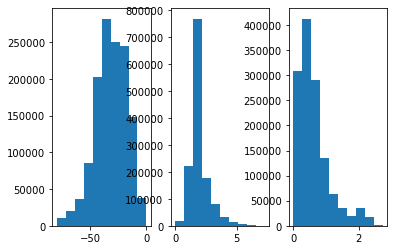

In [92]:
nb_samples = 1000
# Scaled magnitude distribution
x_mel = []
x_pcen_bio = []
x_pcen_sch = []

for idx in range(nb_samples):
    x_mel.append(base_dataset_mel[idx][0].flatten())
    x_pcen_bio.append(base_dataset_pcen_bio[idx][0].flatten())
    x_pcen_sch.append(base_dataset_pcen_sch[idx][0].flatten())

x_mel = np.concatenate(x_mel)
x_pcen_bio = np.concatenate(x_pcen_bio)
x_pcen_sch = np.concatenate(x_pcen_sch)

fig, ax = plt.subplots(1, 3)
ax[0].hist(x_mel)
ax[1].hist(x_pcen_bio)
ax[2].hist(x_pcen_sch)

In [50]:
wav, sample_rate = sed_utils.load_wave('/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/MT/dcase_MK1.wav')

In [51]:
wav_seg = wav[:int(8000*10)]

In [52]:
print("Wav :", np.min(wav), np.max(wav))

Wav : -1967128576.0 1673527296.0


In [53]:
mel = sed_utils.wav_to_mel(wav_seg, sample_rate)
pcen_bio = sed_utils.wav_to_pcen(wav_seg, sample_rate, bioacoustic_conf).astype(np.float32)
pcen_sch = sed_utils.wav_to_pcen(wav_seg, sample_rate, speech_conf).astype(np.float32)


n_frames = mel.shape[1]

mel_ = sed_utils.wav_to_mel(wav, sample_rate)[:,:n_frames]
pcen_bio_ = sed_utils.wav_to_pcen(wav, sample_rate, bioacoustic_conf)[:,:n_frames].astype(np.float32)
pcen_sch_ = sed_utils.wav_to_pcen(wav, sample_rate, speech_conf)[:,:n_frames].astype(np.float32)

In [54]:
print("Mel segment: ", np.min(mel), np.max(mel))
print("Mel all: ", np.min(mel_), np.max(mel_))

print("PCEN (bio) segment: ", np.min(pcen_bio), np.max(pcen_bio))
print("PCEN (bio) all: ", np.min(pcen_bio_), np.max(pcen_bio_))
print("PCEN (sch) segment: ", np.min(pcen_sch), np.max(pcen_sch))
print("PCEN (sch) all: ", np.min(pcen_sch_), np.max(pcen_sch_))
#print(np.max(pcen_bio))
#print(np.max(pcen_bio_))
#print(np.max(pcen_sch))
#print(np.max(pcen_sch_))

Mel segment:  -66.35371817725441 0.0
Mel all:  -78.23258215437845 -11.878863977124041
PCEN (bio) segment:  0.042894013 8.3229
PCEN (bio) all:  0.042894013 8.3229
PCEN (sch) segment:  8.0146696e-05 2.7999055
PCEN (sch) all:  8.0146696e-05 2.7999055


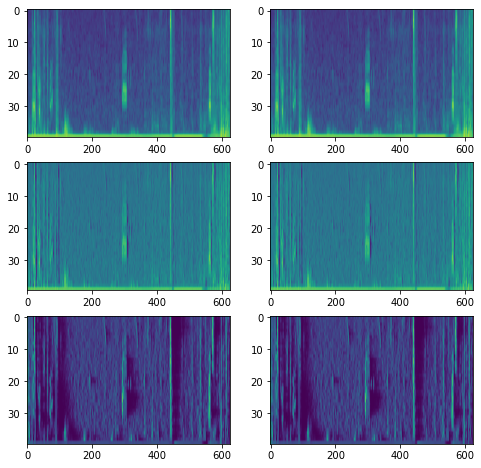

In [55]:
fig, ax = plt.subplots(3, 2, figsize=(8,8))

ax[0,0].imshow(np.flip(mel, axis=0), aspect='auto')
ax[1,0].imshow(np.flip(pcen_bio, axis=0), aspect='auto')
ax[2,0].imshow(np.flip(pcen_sch, axis=0), aspect='auto')

ax[0,1].imshow(np.flip(mel_, axis=0), aspect='auto')
ax[1,1].imshow(np.flip(pcen_bio_, axis=0), aspect='auto')
ax[2,1].imshow(np.flip(pcen_sch_, axis=0), aspect='auto')

In [93]:
np.sum(np.abs(pcen_bio - pcen_bio_) < 1e-6) / pcen_bio.size

0.96484375

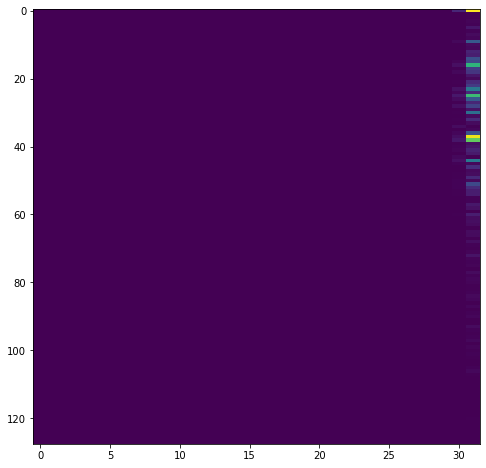

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.abs(pcen_bio - pcen_bio_), aspect='auto')

In [83]:
np.sum(np.abs(mel - mel_) < 1e-6) / mel_.size

0.99609375

# DEPRECATED CODE

In [ ]:
def get_segments_and_labels_old(wave, sample_rate, annotation_df, hop_size, window_size, n_classes, n_time):
    
    # TODO: this needs more testing, and a more general implementation would be beneficial,
    # we want labels scaled by IoU of all overlapping annotations for a segment. This should still be possible to
    # do in O(n log n) time, or possibly O(n log n) if lists are already sorted.
    
#     t1 = time.time()
#     while seg_idx < len(segment_intervals):
#         while segment_interval[0] < annotation_interval[1]:
            
#             iou = compute_interval_intersection_over_union(segment_interval, annotation_interval)
            
#             intersection = compute_interval_intersection(segment_interval, annotation_interval)
#             fraction_annotation_of_segment = intersection / (segment_interval[1]-segment_interval[0])
#             fraction_annotation_in_segment = intersection / (annotation_interval[1]-annotation_interval[0])

#             #iou = compute_interval_intersection_over_union(time_interval, annotation_interval)
#             if fraction_annotation_of_segment > 0.5 or fraction_annotation_in_segment > 0.5:
#                 l = labels[ann_idx]
#             else:
#                 l = (47, 0)
                
#             segment_labels1.append(l)
#             seg_idx += 1
#             segment_interval = segment_intervals[seg_idx]
#             #print("seg_idx: ", seg_idx)
            
#         while segment_interval[0] >= annotation_interval[1]:
#             ann_idx += 1
            
#             if ann_idx >= len(annotation_intervals):
#                 while seg_idx < len(segment_intervals):
#                     segment_labels1.append((47, 0))
#                     seg_idx+=1
#                 break
            
#             annotation_interval = annotation_intervals[ann_idx]
#             #print("ann_idx: ", ann_idx)
#     t2 = time.time()
#     print("classify_with_annotation (new): ", t2-t1)

In [29]:
#file_name = 'BV/2015-09-21_06-00-00_unit05'

root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/'

#wav_path = os.path.join(root_path, file_name) + ".wav"
#csv_path = os.path.join(root_path, file_name) + ".csv"

def check_assumption_1(annotation_intervals):
    for i1 in annotation_intervals:
        for i2 in annotation_intervals:
            iou = compute_interval_intersection_over_union(i1, i2)
            if iou > 0 and iou < 1:
                print("IoU: ", iou, " --> ", i1, " overlaps with ", i2)
                return False
    return True

def check_assumption_2(annotation_intervals, lables):
    assumption = True
    for i in range(len(annotation_intervals)):
        for j in range(i, len(annotation_intervals)):
            i1 = annotation_intervals[i]
            i2 = annotation_intervals[j]
            l1 = labels[i]
            l2 = labels[j]
            iou = compute_interval_intersection_over_union(i1, i2)
            if iou > 0.5 and iou < 1 and l1 != l2:
                print(l1[0], " and ", l2, " IoU: ", iou, " --> ", i1, " overlaps with ", i2)
                assumption = False
    return assumption

def check_assumption_3(annotation_intervals, lables):
    assumption = True
    for i in range(len(annotation_intervals)):
        for j in range(i, len(annotation_intervals)):
            i1 = annotation_intervals[i]
            i2 = annotation_intervals[j]
            l1 = labels[i]
            l2 = labels[j]
            iou = compute_interval_intersection_over_union(i1, i2)
            if iou > 0.0 and iou < 1 and l1 != l2 and l1 != 47 and l2 != 47:
                print(l1, " and ", l2, " IoU: ", iou, " --> ", i1, " overlaps with ", i2)
                assumption = False
    return assumption

def check_assumption_4(annotation_intervals):
    s1 = 0
    assumption = True
    for (s2, _) in annotation_intervals:
        if s2 < s1:
            assumption = False
        s1 = s2
    return assumption

def count_not_same_class_overlapping_annotations(annotation_intervals, lables):
    count = 0
    overlaps = []
    for i in range(len(annotation_intervals)):
        for j in range(i, len(annotation_intervals)):
            i1 = annotation_intervals[i]
            i2 = annotation_intervals[j]
            l1 = labels[i]
            l2 = labels[j]
            iou = compute_interval_intersection_over_union(i1, i2)
            if iou > 0.0 and iou < 1.0 and l1 != l2 and l1 != 47 and l2 != 47:
                overlaps.append(i1)
                overlaps.append(i2)
                #print(l1[0], " and ", l2[0], " IoU: ", iou, " --> ", i1, " overlaps with ", i2)
                #if i1[0] > i2[0]:
                #    overlaps.append((i1, i2))
                #else:
                #    overlaps.append((i2, i1))
    return len(list(set(overlaps)))

csv_paths = glob.glob(os.path.join(root_path, "*/*.csv"))
total_overlaps = 0
total_annotations = 0
total_positive_annotations = 0
total_unknown_annotations = 0

# for csv_path in csv_paths:
#     annotation_df = pd.read_csv(csv_path)
#     annotation_intervals, labels = get_annotation_intervals_and_labels(annotation_df)
#     print(check_assumption_4(annotation_intervals))


for csv_path in csv_paths:
    annotation_df = pd.read_csv(csv_path)
    annotation_intervals, labels = get_annotation_intervals_and_labels(annotation_df)
    
    total_positive_annotations += np.sum([1 if l != 47 else 0 for l in labels])
    total_unknown_annotations += np.sum([0 if l != 47 else 1 for l in labels])
    
    overlaps = count_not_same_class_overlapping_annotations(annotation_intervals, labels)
    print(csv_path)
    print(overlaps/np.sum([1 if l != 47 else 0 for l in labels])) #, " (fraction of annotations which overlaps with other class)", )
    #print(overlaps)
    total_overlaps += overlaps
    total_annotations += len(annotation_intervals)
#print(total_overlaps / total_annotations)
print(total_overlaps / total_positive_annotations)
assert(total_unknown_annotations + total_positive_annotations == total_annotations)

/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/HT/a1.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/HT/e1.csv
0.06153846153846154
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/HT/y1.csv
0.22388059701492538
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/HT/h1.csv
0.07260726072607261
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/HT/n1.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/JD/sp4f1_2015_04_24-05_00_00_0002.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/BV/2015-09-11_06-00-00_unit07.csv
0.010958904109589041
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/BV/2015-09-21_06-00-00_unit05.csv
0.012371134020618556
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_800

/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC185101.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC483697.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC511642.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC515865.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC474017.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC253273.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC538478.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC454603.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/WMW/XC41249.csv
0.0
/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_80

In [ ]:
class BioacousticBaseDatasetOld(torch.utils.data.Dataset):
    """Bioacoustic base dataset."""

    def __init__(self, root_dir, norm_segment_time, hop_time, transform=None):
        """
        Args:
            root_dir: Training_Set with all wav files and annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #csv_paths = glob.glob(os.path.join(root_path, '*/*.csv'))
        csv_paths = [root_dir]
        wav_paths = [x.replace('csv', 'wav') for x in csv_paths]
        
        self.csv_paths = csv_paths
        self.wav_paths = wav_paths
        self.transform = transform

        xs = []
        ys = []
        
        for csv_path, wav_path in tqdm.tqdm(list(zip(csv_paths, wav_paths))):
            wav, sr = librosa.load(wav_path, sr=None)
            
            annotation_df = pd.read_csv(csv_path)
            
            for row in annotation_df.iterrows():
                start_time = row[1][1]
                end_time = row[1][2]
                segment_time = end_time - start_time
                
                if segment_time <= norm_segment_time:
                    # expand segment
                    expand = (norm_segment_time-segment_time)/2
                    
                    if start_time-expand > 0:
                        start_idx = int((start_time-expand)*sr)
                    else:
                        start_idx = int(start_time*sr)

                    end_idx = int((end_time+expand)*sr)
                                        
                    segment  = wav[int(start_idx):int(end_idx)]
                    
                    to_pad = int(sr*norm_segment_time) - len(segment)
                    
                    if to_pad < 0:
                        segment = segment[:to_pad]
                    else:
                        padding = np.zeros(to_pad)
                        segment = np.concatenate((segment, padding))
                    
                    segments = np.expand_dims(segment, axis=0)
                    
                    #print("Case 1: ", segments.shape)
                    #print("start_index: ", start_idx, " end_index: ", end_idx)
                    
                elif segment_time > norm_segment_time:
                    segment = wav[int(start_time*sr):int(end_time*sr)]
                    
                    #n_segments = max_segment_time / end_time
                    #pad_time = np.ceil(n_segments) - n_segments
                    #padding = np.zeros(int(pad_time*sr))
                    #segment = np.concatenate((segment, padding))
                    
                    window_size = int(norm_segment_time*sr)
                    hop_size = int(hop_time*sr)
                    
                    N = len(segment)
                    M = int(np.floor((N-window_size)/hop_size))
                    index = np.array([np.arange(window_size) + hop_size*i for i in range(M+1)])
                    
                    segments = segment[index]

                class_label = 1
                labels = np.ones(len(segments)) * class_label
                
                xs.append(segments)
                ys.append(labels)
            
        self.x = np.concatenate(xs)
        self.y = np.concatenate(ys)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.x[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

In [217]:
# root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/'
# csv_paths = glob.glob(os.path.join(root_path, "*/*.csv"))
# wav_paths = [x.replace('.csv', '.wav') for x in csv_paths]

# # settings
# window_size = 1024 * 16
# hop_size = window_size // 2
# n_classes = 48
# n_time = 8

# signal_segmentss = []
# signal_segment_targetss = []

# background_segmentss = []
# background_segment_targetss = []

# t1 = time.time()
# idx = 10
# for wav_path, csv_path in tqdm.tqdm(list(zip(wav_paths, csv_paths))[idx:idx+1]):

#     print(wav_path)
#     wave, sample_rate = load_wave(wav_path)
#     annotation_df = pd.read_csv(csv_path)

#     print(len(wave)/sample_rate)

#     signal_segments, signal_segment_targets, background_segments, background_segment_targets = get_segments_and_labels(wave, sample_rate, annotation_df, hop_size, window_size, n_classes, n_time)

#     signal_segmentss.append(signal_segments)
#     signal_segment_targetss.append(signal_segment_targets)
    
#     background_segmentss.append(background_segments)
#     background_segment_targetss.append(background_segment_targets)

# t2 = time.time()
# print("total time: ", t2-t1)

  0%|          | 0/1 [00:00<?, ?it/s]

/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/BV/2015-09-25_04-00-00_unit10.wav
7200.0



  1%|          | 48/7030 [00:00<00:14, 467.72it/s]

Number of annotations:  1229
Number of segments:  7030
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 0. 1. 1.


  3%|▎         | 244/7030 [00:00<00:11, 579.64it/s]

Class:  12  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  12  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  13  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  12  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



  6%|▌         | 389/7030 [00:00<00:10, 635.90it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]



  9%|▊         | 606/7030 [00:00<00:09, 643.39it/s]

Class:  25  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  25  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  43  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 10%|█         | 738/7030 [00:01<00:09, 644.58it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  13  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 12%|█▏        | 866/7030 [00:01<00:10, 604.17it/s]

Class:  17  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  17  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  43  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  13  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 14%|█▍        | 1009/7030 [00:01<00:09, 650.57it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  25  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  25  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  43  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 16%|█▌        | 1140/7030 [00:01<00:09, 636.38it/s]

Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  13  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  12  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 18%|█▊        | 1267/7030 [00:01<00:09, 622.59it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  43  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 20%|██        | 1408/7030 [00:02<00:08, 660.42it/s]

Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  25  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  25  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  17  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]



 21%|██        | 1475/7030 [00:02<00:08, 632.09it/s]


Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]


 24%|██▍       | 1675/7030 [00:02<00:08, 614.75it/s]

Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]



 25%|██▍       | 1737/7030 [00:02<00:09, 558.05it/s]

Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  26  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  25  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 26%|██▋       | 1852/7030 [00:02<00:09, 554.34it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]



 28%|██▊       | 1972/7030 [00:03<00:08, 574.35it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 30%|██▉       | 2107/7030 [00:03<00:07, 622.16it/s]

Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



 32%|███▏      | 2245/7030 [00:03<00:07, 653.27it/s]

Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  25  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  25  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]



 34%|███▍      | 2374/7030 [00:03<00:07, 599.64it/s]

Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  26  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  12  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  17  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  17  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  17  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]



 36%|███▌      | 2496/7030 [00:04<00:07, 573.24it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  30  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  30  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]



 36%|███▋      | 2554/7030 [00:04<00:08, 500.59it/s]

Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]



 38%|███▊      | 2678/7030 [00:04<00:07, 552.31it/s]

Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  12  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  12  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  43  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



 41%|████      | 2878/7030 [00:04<00:06, 615.26it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  26  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]



 43%|████▎     | 3015/7030 [00:04<00:06, 642.95it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  13  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 45%|████▍     | 3146/7030 [00:05<00:06, 621.90it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  30  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  30  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  30  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  30  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 47%|████▋     | 3276/7030 [00:05<00:06, 596.18it/s]

Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]



 48%|████▊     | 3406/7030 [00:05<00:06, 580.02it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 51%|█████▏    | 3608/7030 [00:05<00:05, 612.76it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 53%|█████▎    | 3735/7030 [00:06<00:05, 615.36it/s]

Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  12  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]



 55%|█████▌    | 3867/7030 [00:06<00:05, 624.38it/s]

Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 57%|█████▋    | 3998/7030 [00:06<00:04, 625.92it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  43  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  25  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  25  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  25  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 59%|█████▉    | 4139/7030 [00:06<00:04, 660.10it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]



 61%|██████    | 4279/7030 [00:06<00:04, 679.50it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



 63%|██████▎   | 4416/7030 [00:07<00:03, 655.78it/s]


Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]


 65%|██████▍   | 4550/7030 [00:07<00:03, 629.39it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  37  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  26  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]



 67%|██████▋   | 4681/7030 [00:07<00:03, 630.63it/s]

Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  17  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]



 69%|██████▊   | 4822/7030 [00:07<00:03, 664.39it/s]

Class:  26  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  26  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  12  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  12  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  14  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]



 70%|███████   | 4955/7030 [00:07<00:03, 644.13it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 72%|███████▏  | 5086/7030 [00:08<00:03, 637.85it/s]

Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  13  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  13  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 74%|███████▍  | 5222/7030 [00:08<00:02, 631.06it/s]

Class:  26  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  26  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  26  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 76%|███████▌  | 5350/7030 [00:08<00:02, 632.26it/s]

Class:  17  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  17  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  17  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  43  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  17  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]



 78%|███████▊  | 5477/7030 [00:08<00:02, 620.04it/s]

Class:  13  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  13  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  13  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  37  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]



 80%|███████▉  | 5615/7030 [00:08<00:02, 651.85it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  37  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  43  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  30  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  30  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]



 82%|████████▏ | 5757/7030 [00:09<00:01, 678.33it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]



 84%|████████▍ | 5897/7030 [00:09<00:01, 661.92it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  14  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  14  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  14  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  14  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  14  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  14  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  14  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]



 86%|████████▌ | 6036/7030 [00:09<00:01, 661.65it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]



 89%|████████▉ | 6248/7030 [00:09<00:01, 687.38it/s]

Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  37  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]



 92%|█████████▏| 6460/7030 [00:10<00:00, 694.31it/s]

Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



 94%|█████████▍| 6608/7030 [00:10<00:00, 713.28it/s]

Class:  43  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  43  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  17  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  17  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



 96%|█████████▌| 6749/7030 [00:10<00:00, 683.58it/s]

Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  43  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  26  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  26  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]



 98%|█████████▊| 6890/7030 [00:10<00:00, 680.83it/s]

Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  37  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 1. 0. 0.]
Class:  47  annotation  [1. 1. 0. 0. 0. 0. 0. 0.]
Class:  37  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  37  annotation  [0. 0. 0. 1. 1. 0. 0. 0.]
Class:  37  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 1.]
Class:  47  annotation  [0. 0. 1. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 1. 0. 0.]
Class:  47  annotation  [0. 1. 0. 0. 0. 0. 0. 0.]
Class:  43  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]



100%|██████████| 1/1 [00:11<00:00, 12.00s/it]

Class:  47  annotation  [0. 0. 0. 0. 0. 1. 1. 0.]
Class:  47  annotation  [0. 1. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 1. 0.]
Class:  47  annotation  [0. 0. 0. 0. 0. 0. 0. 1.]
Class:  47  annotation  [0. 0. 1. 0. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 1. 0. 0. 0. 0.]
Class:  47  annotation  [0. 0. 0. 0. 1. 0. 0. 0.]
Class:  47  annotation  [1. 0. 0. 0. 0. 0. 0. 0.]
classify_with_annotation:  11.232884645462036
total time:  11.99933123588562


In [12]:
idx_bool_pos = labels[:,0] != 47
idx_bool_unk = (labels[:,1] == 1) & (labels[:,0] == 47)
idx_bool_neg = (labels[:,1] == 0) & (labels[:,0] == 47)

idx_pos = np.arange(len(labels))[idx_bool_pos]
idx_unk = np.arange(len(labels))[idx_bool_unk]
idx_neg = np.arange(len(labels))[idx_bool_neg]

plt.plot(idx_bool_pos, 'b')
plt.plot(idx_bool_unk, 'r')
plt.show()

nb_random = 20
idx_pos_random = np.random.choice(idx_pos, nb_random)
idx_unk_random = np.random.choice(idx_unk, nb_random)
idx_neg_random = np.random.choice(idx_neg, nb_random)


for i in range(len(idx_pos_random)):
    pos_segment = segments[idx_pos_random[i]]
    unk_segment = segments[idx_unk_random[i]]
    neg_segment = segments[idx_neg_random[i]]
    
    fig, ax = plt.subplots(1,3)
    plot_spectrogram(ax[0], pos_segment, sample_rate)
    plot_spectrogram(ax[1], unk_segment, sample_rate)
    plot_spectrogram(ax[2], neg_segment, sample_rate)
    ax[0].set_title('POS')
    ax[1].set_title('UNK')
    ax[2].set_title('NEG')
    plt.show()

NameError: name 'labels' is not defined

In [212]:
def count_occurences(row, category):
    classes = row[1][3:]
    occurances = [1 if x else 0 for x in classes == category]
    
    return sum(occurances)

one_pos     = lambda row: count_occurences(row, 'POS') == 1
count = 0
for row in annotation_df.iterrows():
    if one_pos(row):
        count+=1
        print([row[1][1], row[1][2]])
        
#print(count)

[132.109926, 132.251]
[132.91339299999999, 133.05656499999998]
[186.791, 186.936222]
[187.26, 187.352]
[193.29317, 193.465748]
[194.775211, 194.94099999999997]
[195.435453, 195.531024]
[195.581229, 195.707167]
[196.459, 196.649]
[200.447443, 200.597933]
[202.7714, 202.912]
[206.004248, 206.140151]
[208.858, 208.976]
[227.39262999999997, 227.56180099999997]
[558.3, 558.456]
[566.3660719999999, 566.502]
[586.2869999999999, 586.433]
[590.916509, 591.020634]
[592.147412, 592.2959999999999]
[595.339913, 595.4902900000001]
[597.3022990000001, 597.477]
[131.636, 131.71]
[131.799252, 131.903377]
[132.287, 132.39600000000002]
[23.821275, 23.914987]
[25.463852, 25.591404999999998]
[26.096413000000002, 26.216157]
[26.413996, 26.549358]
[27.023128999999997, 27.174111]
[70.16199999999999, 70.287207]
[70.393, 70.51899999999999]
[70.578758, 70.68028100000001]
[70.755771, 70.823453]
[70.8625, 70.969]
[70.969, 71.074]
[71.156654, 71.268589]
[71.307636, 71.448205]
[71.497664, 71.697]
[71.70851800000001,